# Leakage coefficient fit

> *This notebook estracts the leakage coefficient from the set of 4 multi-spot smFRET measurements.*

##Load FRETBursts software

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------


 You are running FRETBursts (version 0.4rc10-7-gb2e1b5d).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import os
from IPython.display import display, Math
%matplotlib inline

In [3]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import display
from IPython.utils.traitlets import link

##Data files

In [4]:
data_dir = './data/2013-05-15/'

In [5]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

In [6]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))
labels = ['12d', '17d', '22d', '27d', '7d', 'DO']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\12d_New_30p_320mW_steer_3.hdf5',
 '17d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\17d_100p_320mW_steer_1.hdf5',
 '22d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\22d_30p_320mW_steer_1.hdf5',
 '27d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\27d_50p_320mW_steer_1.hdf5',
 '7d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\7d_New_150p_320mW_steer_3.hdf5',
 'DO': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2013-05-15\\DO12_No2_50p_320mW_steer_1.hdf5'}

## 8-spot paper plot style

In [7]:
PLOT_DIR = './figure/'

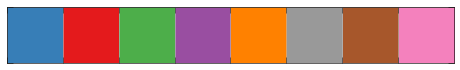

In [8]:
import seaborn as sns
%run -i styles/style.py
#np.set_printoptions(formatter={'float': lambda x: '%6.2f'%x})
import matplotlib as mpl

# brewer2mpl.get_map args: set name  set type  number of colors
#bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.color_cycle'] = list(colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

##Parameters

Analysis parameters:

In [9]:
## Background fit
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,
                 )

## Burst search
F = 6
ph_sel = Ph_sel(Dex='Dem') 
#ph_sel = Ph_sel('all') 
size_min = 80

## D-only peak fit with KDE
bandwidth=0.03
E_range_do = (-0.05, 0.1)
weights = 'size'

In [10]:
import pandas as pd

In [11]:
E_do = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8))
E_do_g = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8))
nbursts = pd.DataFrame(index=['7d', '12d', '17d', 'DO'], columns=range(8))

##Utility functions

In [12]:
def print_fit_report(E_pr, gamma=1, leakage=0, dir_ex_t=0, math=True):
    """Print fit and standard deviation for both corrected and uncorrected E
    Returns d.E_fit.
    """
    E_corr = fretmath.correct_E_gamma_leak_dir(E_pr, gamma=gamma, leakage=leakage, dir_ex_t=dir_ex_t)
    
    E_pr_mean = E_pr.mean()*100
    E_pr_delta = (E_pr.max() - E_pr.min())*100
    
    E_corr_mean = E_corr.mean()*100
    E_corr_delta = (E_corr.max() - E_corr.min())*100
    if math:
        display(Math(r'\text{Pre}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_pr_mean, E_pr_delta)))
        display(Math(r'\text{Post}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_corr_mean, E_corr_delta)))
    else:
        print 'Pre-gamma  E (delta, mean):  %.2f  %.2f' % (E_pr_mean, E_pr_delta)
        print 'Post-gamma E (delta, mean):  %.2f  %.2f' % (E_corr_mean, E_corr_delta)

## 7bp sample

In [13]:
data_id = '7d'
d7 = loader.photon_hdf5(files_dict[data_id])
d7.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [14]:
d7.burst_search(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [15]:
ds7 = Sel(d7, select_bursts.nd, th1=size_min)
dx = ds7

In [16]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
do_s = Sel(dx, select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

 - Adding parameter "fwhm"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

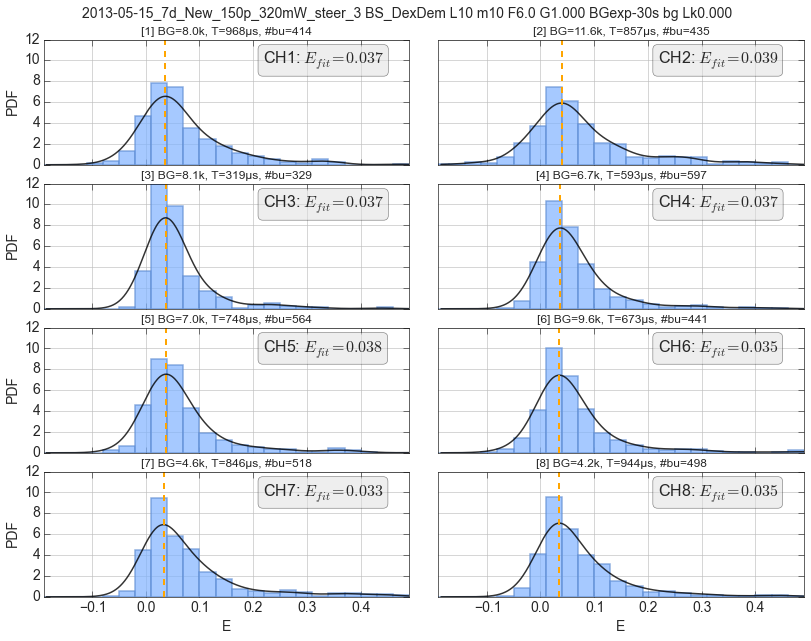

In [17]:
dplot(dx, hist_fret, weights='size', show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

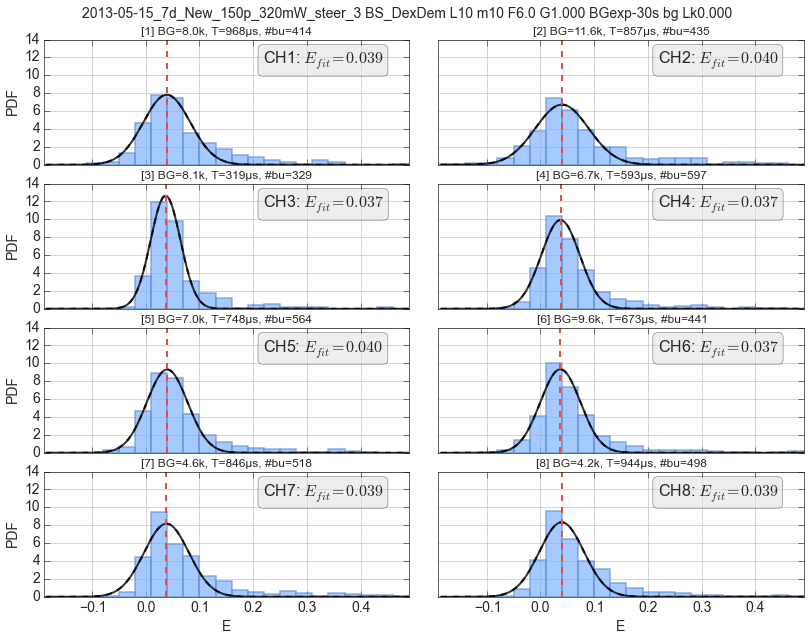

In [18]:
dplot(dx, hist_fret, weights='size', show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

### Alternative plots

<IPython.core.display.Math object>

<IPython.core.display.Math object>

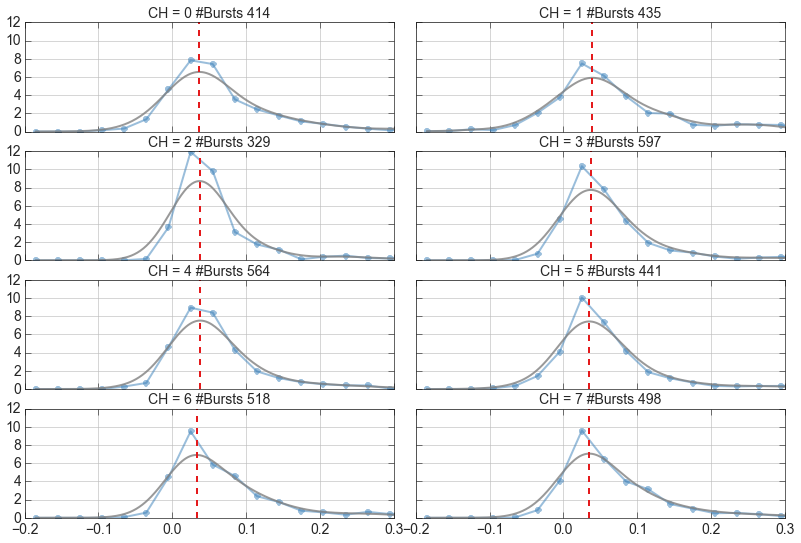

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.18)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(dx.E_fitter, ich=ich, ax=ax, plot_model=False, plot_kde=True)
plt.xlim(-0.2, 0.3)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

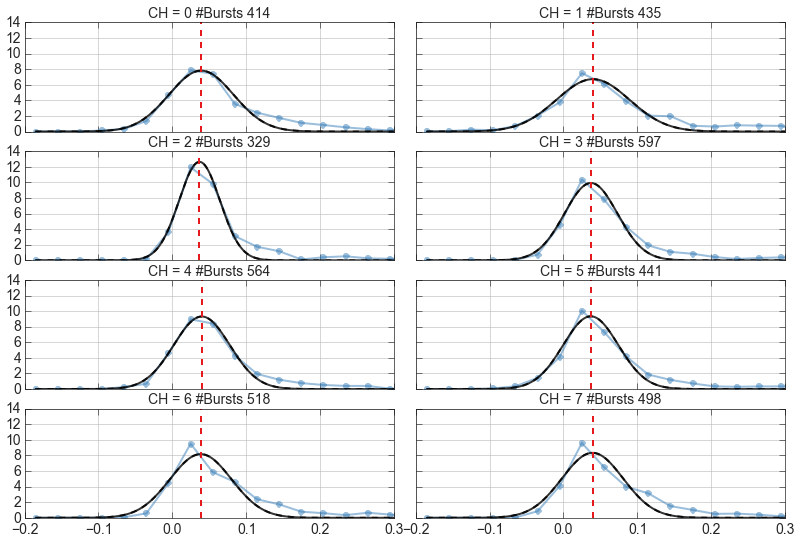

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(left=0.08, right=0.96, top=0.93, bottom=0.07,
                    wspace=0.06, hspace=0.18)

for ich, ax in enumerate(axes.ravel()):
    mfit.plot_mfit(dx.E_fitter, ich=ich, ax=ax)
plt.xlim(-0.2, 0.3)
print_fit_report(E_do_g.loc[data_id])

## 12bp sample

In [21]:
data_id = '12d'
d12 = loader.photon_hdf5(files_dict[data_id])
d12.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [22]:
d12.burst_search_t(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [23]:
ds12 = Sel(d12, select_bursts.nd, th1=size_min)
dx = ds12

In [24]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
do_s = Sel(dx, select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

 - Adding parameter "fwhm"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

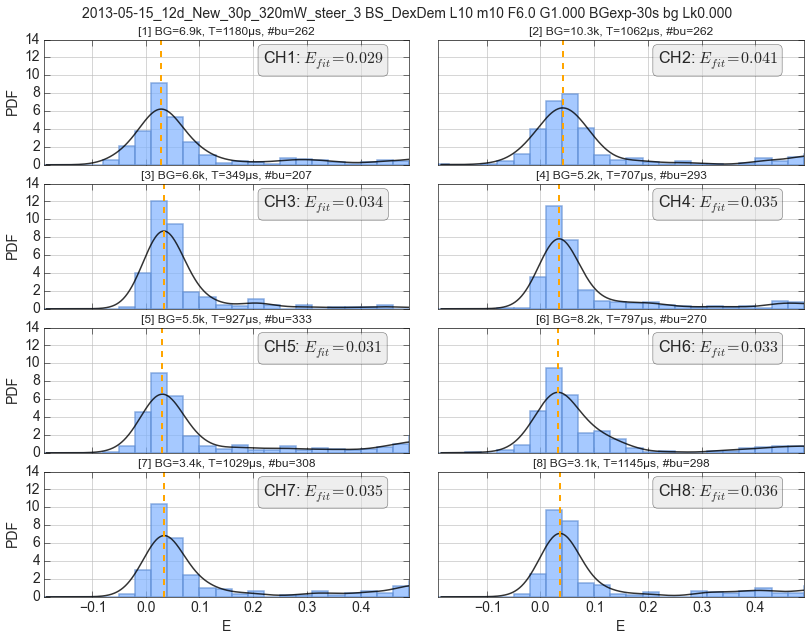

In [25]:
dplot(dx, hist_fret, weights='size', show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

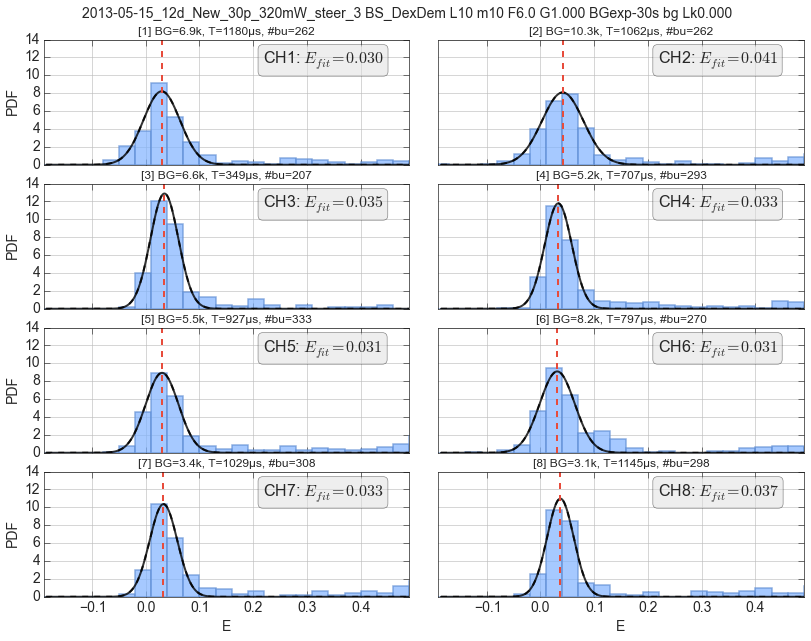

In [26]:
dplot(dx, hist_fret, weights='size', show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

## 17bp sample

In [27]:
data_id = '17d'
d17 = loader.photon_hdf5(files_dict[data_id])
d17.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [28]:
d17.burst_search_t(m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [29]:
ds17 = Sel(d17, select_bursts.nd, th1=size_min)
dx = ds17

In [30]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.fit_histogram(mfit.factory_two_gaussians(p1_center=0.03, p2_center=0.25))
E_do_g.loc[data_id] = dx.E_fitter.params['p1_center']

## D-only selection
do_s = Sel(dx, select_bursts.E, E2=0.1)
nbursts.loc[data_id] = do_s.num_bursts

 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"
 - Adding parameter "p1_fwhm"
 - Adding parameter "p2_fwhm"


 - Adding parameter "p1_fwhm"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

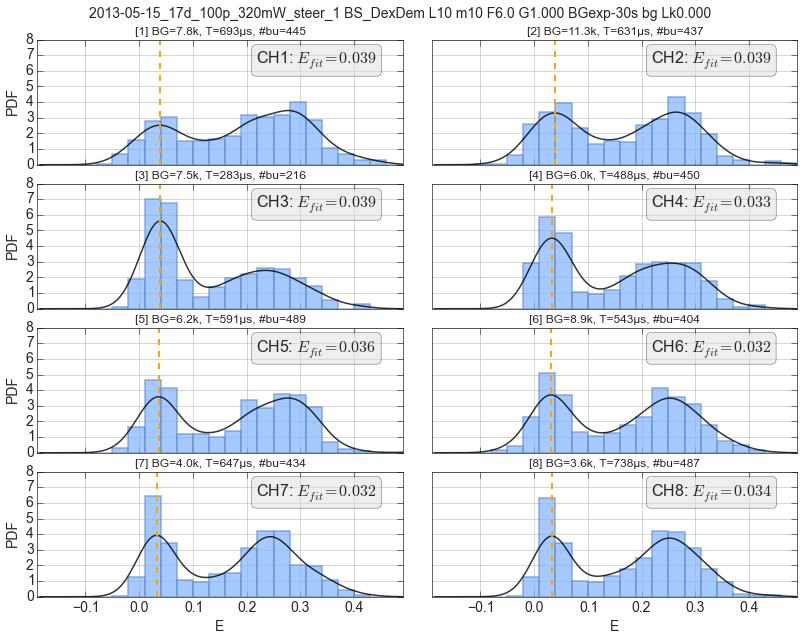

In [31]:
dplot(dx, hist_fret, weights='size', show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

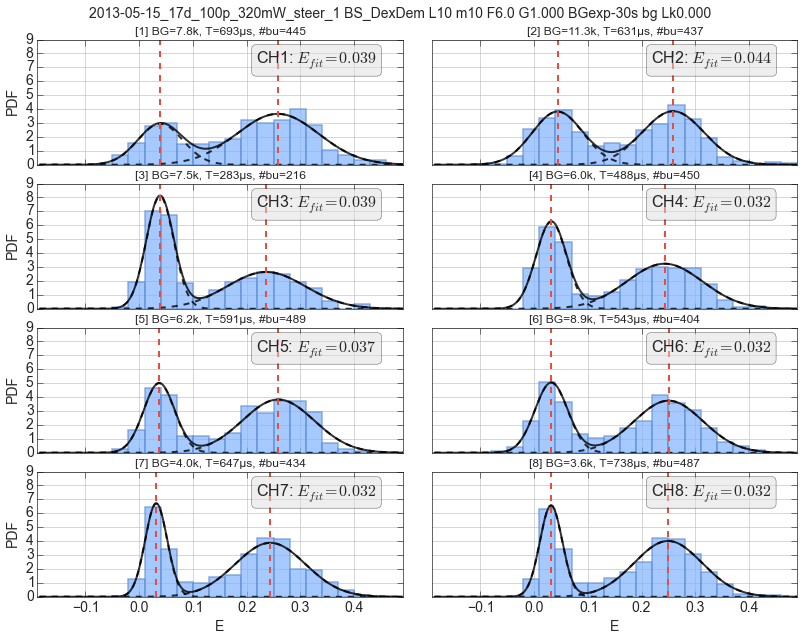

In [32]:
dplot(dx, hist_fret, weights='size', show_model=True, show_fit_value=True, fit_from='p1_center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

## DO sample

In [33]:
data_id = 'DO'
do = loader.photon_hdf5(files_dict[data_id])
do.calc_bg(**bg_kwargs_auto)

 - Calculating BG rates ... 

[DONE]


In [34]:
do.burst_search_t(L=10, m=10, F=F, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [35]:
dos = Sel(do, select_bursts.nd, th1=size_min)
dx = dos

In [36]:
## KDE Fit
E_do.loc[data_id] = bext.fit_bursts_kde_peak(dx, bandwidth=bandwidth, x_range=E_range_do,  
                                             weights=weights)

## Gaussian fit
dx.E_fitter.fit_histogram(mfit.factory_gaussian())
E_do_g.loc[data_id] = dx.E_fitter.params['center']

## D-only selection
nbursts.loc[data_id] = dx.num_bursts

 - Adding parameter "fwhm"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

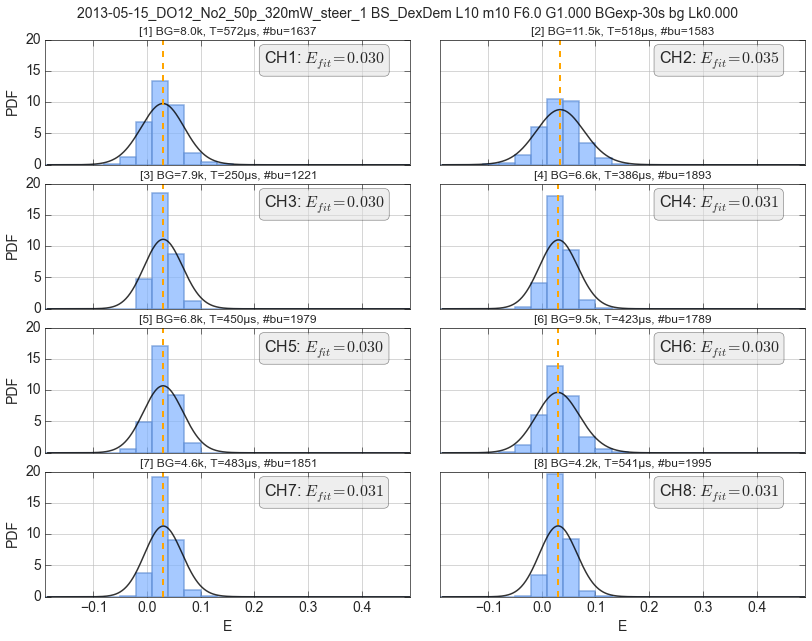

In [37]:
dplot(dx, hist_fret, weights='size', show_kde=True, show_kde_peak=True, show_fit_value=True);
plt.xlim(xmax = 0.49)
print_fit_report(E_do.loc[data_id])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

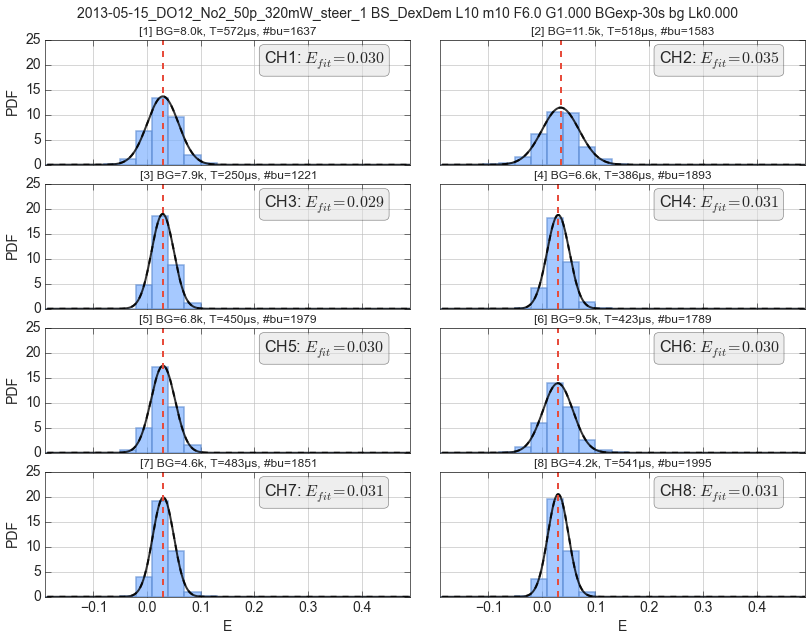

In [38]:
dplot(dx, hist_fret, weights='size', show_model=True, show_fit_value=True, fit_from='center');
plt.xlim(xmax = 0.49)
print_fit_report(E_do_g.loc[data_id])

# Results

In [39]:
ph_sel

Ph_sel(Dex='Dem', Aex=None)

In [40]:
E_do_kde = E_do.copy()

In [41]:
E_do = E_do_kde

In [42]:
leakage = E_do / (1 - E_do)
leakage

,0,1,2,3,4,5,6,7
7d,0.03820598,0.04101603,0.03863731,0.03863731,0.03950104,0.03648425,0.03434009,0.03648425
12d,0.02965404,0.04318798,0.03498241,0.03584007,0.03220479,0.03369857,0.03584007,0.03777501
17d,0.04014978,0.04036621,0.04101603,0.03434009,0.03755966,0.03263114,0.03348491,0.03476821
DO,0.03071532,0.03584007,0.03135314,0.03220479,0.03114044,0.03092784,0.03156592,0.03156592


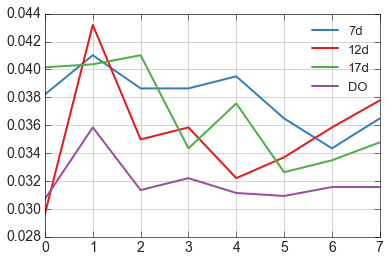

In [43]:
leakage.T.plot();

## Average leakage

### Mean per sample:

In [44]:
lk_s = pd.DataFrame(index=['mean', 'std'], columns=E_do.index)

lk_s.loc['mean'] = leakage.mean(1)*100
lk_s.loc['std'] = leakage.std(1)*100

lk_s['mean'] = lk_s.mean(1)
lk_s

,7d,12d,17d,DO,mean
mean,3.791328,3.539787,3.678951,3.191418,3.550371
std,0.2074819,0.4017379,0.3398287,0.1650247,0.278518


(2, 4)

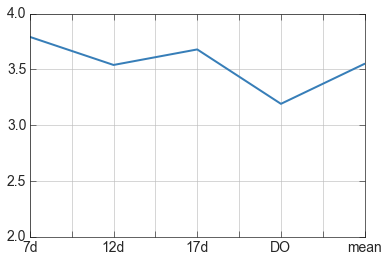

In [45]:
lk_s.loc['mean'].plot()
ylim(2, 4)

### Mean per sample (weighted on the number of bursts):

In [46]:
nbursts

,0,1,2,3,4,5,6,7
7d,318,329,288,504,465,365,397,392
12d,197,199,177,235,237,203,223,217
17d,144,178,119,205,190,165,171,189
DO,1637,1583,1221,1893,1979,1789,1851,1995


In [47]:
lk_sw = pd.DataFrame(index=['mean', 'std'], columns=E_do.index)

lk_sw.loc['mean'] = (nbursts*leakage).sum(1)/nbursts.sum(1)*100
lk_sw.loc['std'] = (nbursts*leakage).std(1)/nbursts.sum(1)*100

lk_sw['mean'] = (nbursts.sum(1)*lk_sw).sum(1)/nbursts.sum(1).sum()
lk_sw

,7d,12d,17d,DO,mean
mean,3.788885,3.537524,3.652092,3.187704,3.340331
std,0.09557339,0.06205046,0.06509532,0.05793074,0.064503


(2, 4)

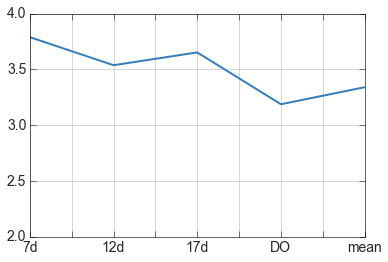

In [48]:
lk_sw.loc['mean'].plot()
ylim(2, 4)

### Mean per channel:

In [49]:
lk_c = pd.DataFrame(index=['mean', 'std'], columns=E_do.columns)

lk_c.loc['mean'] = leakage.mean()*100
lk_c.loc['std'] = leakage.std()*100

lk_c['mean'] = lk_c.mean(1)
lk_c

,0,1,2,3,4,5,6,7,mean
mean,3.468128,4.010257,3.649722,3.525556,3.510148,3.343545,3.380775,3.514835,3.550371
std,0.5270359,0.3087212,0.4233041,0.2703279,0.4061174,0.233091,0.1783605,0.2687148,0.326959


(2, 4)

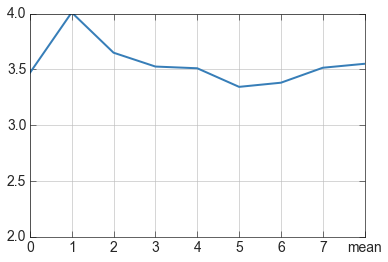

In [50]:
lk_c.loc['mean'].plot()
ylim(2, 4)

### Mean per channel (weighted on the number of bursts):

In [51]:
lk_cw = pd.DataFrame(index=['mean', 'std'], columns=E_do.columns)

lk_cw.loc['mean'] = (nbursts*leakage).sum()/nbursts.sum()*100
lk_cw.loc['std'] = (nbursts*leakage).std()/nbursts.sum()*100

lk_cw['mean'] = lk_cw.mean(1)
lk_cw

,0,1,2,3,4,5,6,7,mean
mean,3.225344,3.757479,3.350832,3.380296,3.300724,3.206645,3.246775,3.295532,3.345453
std,0.9315352,1.032921,0.8683383,0.891054,0.8991996,0.9381662,0.9416672,0.9612965,0.933022


(2, 4)

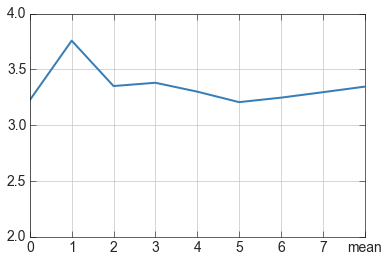

In [52]:
lk_cw.loc['mean'].plot()
ylim(2, 4)

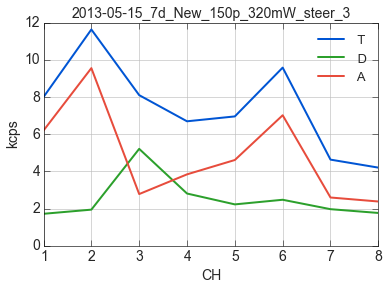

In [53]:
mch_plot_bg(d7)

> **NOTE:** There is a per-channel trend that cannot be ascribed to the background 
> because we performend a D-emission burst search and selection and the leakage vs ch
> does not resemble the D-background vs channel curve.
>
> The effect is probably due to slight PDE variations that change the $\gamma$ 
> on a per-spot basis.

### Weighted mean of the weighted mean

In [54]:
lk = (lk_cw.ix['mean', :-1]*nbursts.mean()).sum()/(nbursts.mean().sum())/100
lk_2 = (lk_sw.ix['mean', :-1]*nbursts.mean(1)).sum()/(nbursts.mean(1).sum())/100

assert np.allclose(lk, lk_2)

print 'Mean leakage: ', lk

Mean leakage:  0.0334033141717


## Save results

In [55]:
if ph_sel == Ph_sel('all'):
    bsearch_str = 'all-ph'
elif ph_sel == Ph_sel(Dex='Dem'):
    bsearch_str = 'Dem'

### Per-channel

In [56]:
lk_cw.to_csv('results/Multi-spot - leakage coefficient mean per-ch %s.txt' % bsearch_str)

In [57]:
pd.read_csv('results/Multi-spot - leakage coefficient mean per-ch %s.txt' % bsearch_str, 
            index_col=0)

,0,1,2,3,4,5,6,7,mean
mean,3.225344,3.757479,3.350832,3.380296,3.300724,3.206645,3.246775,3.295532,3.345453
std,0.931535,1.032921,0.868338,0.891054,0.899200,0.938166,0.941667,0.961296,0.933022


### Per-sample

In [58]:
lk_sw.to_csv('results/Multi-spot - leakage coefficient mean per-sample %s.txt' % bsearch_str)

In [59]:
pd.read_csv('results/Multi-spot - leakage coefficient mean per-sample %s.txt' % bsearch_str, 
            index_col=0)

,7d,12d,17d,DO,mean
mean,3.788885,3.537524,3.652092,3.187704,3.340331
std,0.095573,0.062050,0.065095,0.057931,0.064503


### Mean

In [60]:
with open('results/Multi-spot - leakage coefficient %s.txt' % bsearch_str, 'w') as f:
    f.write(str(lk))

# Notebook style

In [61]:
from IPython.core.display import HTML
HTML(open("./styles/custom.css", "r").read())